In [ ]:
import pandas as pd
from numpy.random import logistic
from tensorflow_estimator.python.estimator.estimator_export import estimator_export

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from model import optimize_function,optimize,optimize_stacking

from sklearn.linear_model import LogisticRegression # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier # K近傍法
from sklearn.svm import SVC # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier # 決定木
from sklearn.ensemble import RandomForestClassifier # ランダムフォレスト
from lightgbm import LGBMClassifier #LGBM
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.naive_bayes import GaussianNB # ナイーブ・ベイズ

from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score

データの読み込みと分割

In [ ]:
# データの読み込み
data = pd.read_csv('../../data/preprocessed_data.csv')

# 特徴量とターゲット変数の分割
X = data.drop('dengue', axis=1)  
y = data['dengue']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

各分類機の最適化

In [ ]:
optimize_function=optimize_function(X_train,y_train)

In [ ]:
objectives_dict={"Logistic Regression" : optimize_function.objective_logistic_regression,
                 "Nearest Neighbors" : optimize_function.objective_knn, 
                 "RBF SVM" : optimize_function.objective_svm_rbf, 
                 "Decision Tree" : optimize_function.objective_decision_tree,
                 "Random Forest" : optimize_function.objective_random_forest,
                 "LGBM" : optimize_function.objective_lgbm,
                 "AdaBoost" : optimize_function.objective_adaboost, 
                 "Naive Bayes": optimize_function.objective_naive_bayes
                 }

In [ ]:
optimize=optimize(objectives_dict)
best_params=optimize.optimize()

In [ ]:
df_best_params=pd.DataFrame.from_dict(best_params,orient='index')
df_best_params.to_csv('best_params/best_params.csv')

In [ ]:
best_params_df=pd.read_csv('best_params/best_params.csv')
best_params_df

スタッキングモデルの構築

In [30]:
names = ['Nearest Neighbors', 'RBF SVM', 
         'Decision Tree','Random Forest','AdaBoost']

classifiers = [SVC(kernel="rbf",C=0.35,gamma='scale',class_weight='balanced',probability=True),
               KNeighborsClassifier(n_neighbors=69,weights='distance',algorithm='auto'),
               DecisionTreeClassifier(criterion='entropy',max_depth=30,min_samples_split=27,min_samples_leaf=100,class_weight='balanced'),
               RandomForestClassifier(max_depth=45,min_samples_split=43,min_samples_leaf=55,n_estimators=914,class_weight='balanced'),
               AdaBoostClassifier(algorithm='SAMME',n_estimators=445,learning_rate=0.001)]

In [26]:
optimize_stacking=optimize_stacking(names,classifiers,X_train,y_train)
objective_stacking=optimize_stacking.objective_stacking
optimize_stacking.optimize_stacking(objective_stacking)

TypeError: 'optimize_stacking' object is not callable

In [31]:
# 最適化したスタッキングモデルの構築
#meta_model = LGBMClassifier(num_leaves=611,learning_rate=0.073,n_estimators=897,lambda_l1=15,lambd_l2=39) #LGBM
meta_model=LogisticRegression()
estimator=[(name,clf) for name,clf in zip(names,classifiers)]
stacking_clf = StackingClassifier(estimators=estimator, final_estimator=meta_model)
stacking_clf.fit(X_train, y_train)


StackingClassifier(estimators=[('Nearest Neighbors',
                                SVC(C=0.35, class_weight='balanced',
                                    probability=True)),
                               ('RBF SVM',
                                KNeighborsClassifier(n_neighbors=69,
                                                     weights='distance')),
                               ('Decision Tree',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       criterion='entropy',
                                                       max_depth=30,
                                                       min_samples_leaf=100,
                                                       min_samples_split=27)),
                               ('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=45,
                                                       min_samples_leaf=55,
                                                       min_samples_split=43,
                                                       n_estimators=914)),
                               ('AdaBoost',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   learning_rate=0.001,
                                                   n_estimators=445))],
                   final_estimator=LogisticRegression())

In [32]:
#テスト・比較
result = []

#各機械学習モデルのテスト
for name, clf in zip(names, classifiers): 
    clf.fit(X_train, y_train) 
    score1 = clf.score(X_train, y_train) 
    score2 = clf.score(X_test, y_test) 
    result.append([score1, score2]) 

result = pd.DataFrame(result, columns=['train', 'test'], index=names)

#スタッキングモデルのテスト
y_pred = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

stacking_score1 = stacking_clf.score(X_train, y_train)
stacking_score2 = stacking_clf.score(X_test, y_test)

stacking_result = pd.DataFrame([[stacking_score1, stacking_score2]], columns=['train', 'test'], index=['Stacking'])

# 既存の結果とスタッキング結果を結合
result_df = pd.concat([pd.DataFrame(result, columns=['train', 'test'], index=names), stacking_result])
result_df = result_df.sort_values('test', ascending=False)

print(result_df)


                      train      test
RBF SVM            0.946906  0.642857
Stacking           0.919544  0.634498
Nearest Neighbors  0.659283  0.628419
Decision Tree      0.664169  0.623860
AdaBoost           0.628990  0.619301
Random Forest      0.650814  0.618541


<Axes: >

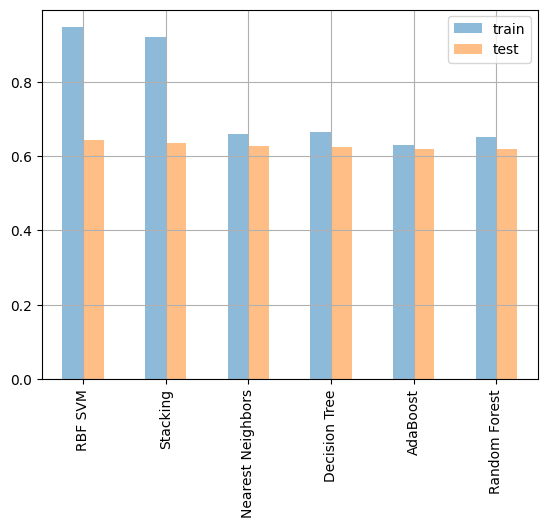

In [33]:
result_df.plot(kind='bar', alpha=0.5, grid=True)